> Introdução à Ciência dos Dados \
> Ciência da Computação – UFV/Florestal


* **Nome:** lucas takeshi, Jonathan Lopes, Matheus Silva
* **Matrícula:** 2665, 2666, 2649

----
# Importação dos Dados

In [96]:
### NÃO REMOVA ESSA CÉLULA! ####

!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_lobby_stats_player.csv
!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_medalha.csv
!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_players.csv
!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_players_medalha.csv

--2022-07-07 00:03:18--  https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_lobby_stats_player.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28373607 (27M) [text/plain]
Saving to: ‘tb_lobby_stats_player.csv.4’

tb_lobby_stats_play 100%[===================>]  27.06M   146MB/s    in 0.2s    

2022-07-07 00:03:18 (146 MB/s) - ‘tb_lobby_stats_player.csv.4’ saved [28373607/28373607]

--2022-07-07 00:03:18--  https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_medalha.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [97]:
#### Não altere essa célula!!! ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [98]:
original_df_lobby = pd.read_csv('./tb_lobby_stats_player.csv')
original_df_players = pd.read_csv('./tb_players.csv')
df_l =original_df_lobby
df_p =original_df_players
#Informações de players
#df_p.info()
#tratando os dados de players
df_p = df_p.drop("flFacebook",axis=1)
df_p = df_p.drop("flTwitter",axis=1)
df_p = df_p.drop("flTwitch",axis=1)
df_p = df_p.drop("dtBirth",axis=1)
df_p['dtRegistration'] = pd.to_datetime(df_p['dtRegistration'], infer_datetime_format=True)
df_l['qtSurvived'].fillna('drop', inplace=True)
#drop dos NAN
drop=df_l[df_l["qtSurvived"]=='drop'].index
df_l=df_l.drop(drop)
#Informações de players
#df_p.info()
#Informações de lobby
#df_l.info()
#tratando os dados de lobby
df_l = df_l.drop("qtShots",axis=1)
df_l = df_l.drop("qtPlusKill",axis=1)
df_l = df_l.drop("dtCreatedAt",axis=1)
df_l = df_l.drop("qtHitRightLeg",axis=1)
df_l = df_l.drop("qtHitLeftLeg",axis=1)
df_l = df_l.drop("qtHitRightArm",axis=1)
df_l = df_l.drop("qtHitLeftAtm",axis=1)
df_l = df_l.drop("qtHitStomach",axis=1)
df_l = df_l.drop("qtHitChest",axis=1)
df_l = df_l.drop("qtHitHeadshot",axis=1)
df_l = df_l.drop("qtTk",axis=1)
df_l = df_l.drop("qtTkAssist",axis=1)
#Informações de lobby
#df_l.info()
#criação de dados categóricos de acordo com cada parametro
#STATS na coluna de jogador junto com teste de hipotese para verificar se o player morre menos

In [99]:
#df_l.info()
#drop de rounds menores que o primeiro quartil para ter apenas players que jogaram uma quantidade consideravel de rounds
drop=df_l[df_l['qtRoundsPlayed']<df_l['qtRoundsPlayed'].quantile(0.25)].index
df_l=df_l.drop(drop)
df_l['qtRoundsPlayed'].describe()


count    146441.000000
mean         28.358691
std           4.582400
min          23.000000
25%          25.000000
50%          28.000000
75%          30.000000
max          84.000000
Name: qtRoundsPlayed, dtype: float64

In [100]:
# Calcular kill por round
def kpr(kills, rounds):
  kpr = kills/rounds #quanto mais alto melhor 
  return kpr

def dpr(deaths, rounds): #quanto mais próximo de 0 melhor
  dpr = deaths/rounds
  return dpr

#qtAssist - 15, qtBombePlant - 15, qtBombeDefuse - 20, qtClutchWon - 20, qtTrade - 10, qtFlashAssist - 10, qtFirstKill - 10
def distPoints(qtAssist, qtBombePlant, qtBombeDefuse, qtClutchWon, qtTrade, qtFlashAssist, qtFirstKill):
  qtAssist = qtAssist*15
  qtBombePlant = qtBombePlant*15
  qtBombeDefuse = qtBombeDefuse*20
  qtClutchWon = qtClutchWon*20
  qtTrade = qtTrade*10
  qtFlashAssist = qtFlashAssist*10
  qtFirstKill = qtFirstKill*10
  total = (qtAssist+qtBombePlant+qtBombeDefuse+qtClutchWon+qtTrade+qtFlashAssist+qtFirstKill)/7
  return total

df_l.insert((df_l.shape[1]),"kpr",kpr(df_l['qtKill'], df_l['qtRoundsPlayed']),True) #Kills Per Round
df_l.insert((df_l.shape[1]),"dpr",dpr(df_l['qtDeath'], df_l['qtRoundsPlayed']),True) #Deaths Per Round
df_l.insert((df_l.shape[1]),"pps",distPoints(df_l['qtAssist'], df_l['qtBombePlant'], df_l['qtBombeDefuse'], df_l['qtClutchWon'], df_l['qtTrade'], df_l['qtFlashAssist'], df_l['qtFirstKill']),True) #Points Per Stats
df_l.insert((df_l.shape[1]),"playerQuality",'Null',True) #Player Quality
df_l



,idLobbyGame,idPlayer,idRoom,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qt1Kill,...,descMapName,vlLevel,qtSurvived,qtTrade,qtFlashAssist,flWinner,kpr,dpr,pps,playerQuality
1,2,1,2,24,3,18,6,0,4,9,...,de_nuke,9,8.0,1.0,0.0,1,0.888889,0.666667,23.571429,Null
2,3,2,3,6,4,23,2,0,1,4,...,de_mirage,2,2.0,3.0,0.0,0,0.240000,0.920000,17.857143,Null
3,3,391,27508,10,5,20,4,1,0,6,...,de_mirage,15,3.0,4.0,0.0,1,0.400000,0.800000,23.571429,Null
4,4,2,4,8,4,26,6,0,2,4,...,de_nuke,2,4.0,4.0,2.0,0,0.266667,0.866667,22.857143,Null
11,10,2,10,19,2,21,7,0,0,9,...,de_mirage,2,6.0,3.0,3.0,0,0.703704,0.777778,18.571429,Null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184146,172906,2716,178495,17,3,19,7,0,2,12,...,de_mirage,9,9.0,4.0,0.0,0,0.607143,0.678571,20.714286,Null
184147,172907,2716,178496,21,3,13,5,1,1,8,...,de_vertigo,9,11.0,0.0,0.0,1,0.807692,0.500000,15.714286,Null
184148,172908,2716,178497,15,1,22,5,0,1,11,...,de_nuke,9,7.0,5.0,0.0,1,0.517241,0.758621,18.571429,Null
184149,172909,2716,178498,9,6,23,2,0,3,9,...,de_vertigo,9,4.0,2.0,0.0,0,0.333333,0.851852,25.000000,Null


In [101]:
def playerQuality(df):
  for i in df.index:
    if (df['pps'][i] <= 20.0):
      df['playerQuality'][i] = 'Ruim'
    elif ((df['pps'][i] > 20.0)&(df['pps'][i] <= 40.0)):
      df['playerQuality'][i] = 'Regular'
    elif ((df['pps'][i] > 40.0)&(df['pps'][i] <= 60.0)):
      df['playerQuality'][i] = 'Bom'
    elif ((df['pps'][i] > 60.0)&(df['pps'][i] <= 80.0)):
      df['playerQuality'][i] = 'Muito Bom'
    elif (df['pps'][i] > 80.0):
      df['playerQuality'][i] = 'Excelente'

In [102]:
playerQuality(df_l)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: Sett

In [103]:
df_l['playerQuality'].value_counts()

Regular      88040
Ruim         52934
Bom           5350
Muito Bom      114
Excelente        3
Name: playerQuality, dtype: int64

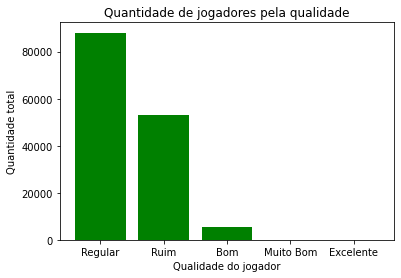

In [104]:
plt.bar(df_l['playerQuality'].unique(),df_l['playerQuality'].value_counts(), color='green')
plt.ylabel('Quantidade total')
plt.xlabel('Qualidade do jogador')
plt.title('Quantidade de jogadores pela qualidade')
plt.show()

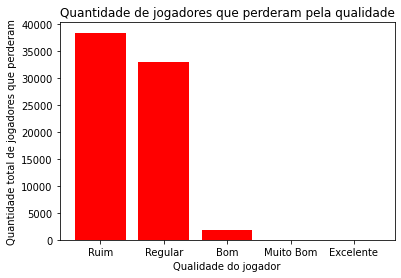

In [105]:
playersLosers = df_l[df_l["flWinner"]==0]
plt.bar(playersLosers['playerQuality'].unique(),playersLosers['playerQuality'].value_counts(), color='red')
plt.ylabel('Quantidade total de jogadores que perderam')
plt.xlabel('Qualidade do jogador')
plt.title('Quantidade de jogadores que perderam pela qualidade')
plt.show()

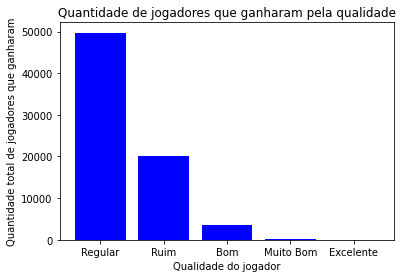

In [106]:
playersWinners = df_l[df_l["flWinner"]==1]
plt.bar(playersWinners['playerQuality'].unique(),playersWinners['playerQuality'].value_counts(), color='blue')
plt.ylabel('Quantidade total de jogadores que ganharam')
plt.xlabel('Qualidade do jogador')
plt.title('Quantidade de jogadores que ganharam pela qualidade')
plt.show()

In [107]:
playersLosers['playerQuality'].value_counts()

Regular      38329
Ruim         32925
Bom           1902
Muito Bom       41
Excelente        2
Name: playerQuality, dtype: int64

In [108]:
playersWinners['playerQuality'].value_counts()

Regular      49711
Ruim         20009
Bom           3448
Muito Bom       73
Excelente        1
Name: playerQuality, dtype: int64

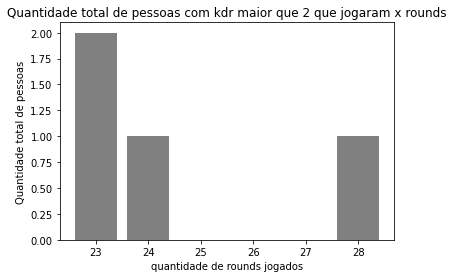

In [109]:
vg = df_l[df_l['kpr']>=2]
plt.bar(vg['qtRoundsPlayed'].unique(), vg['qtRoundsPlayed'].value_counts(), color='gray')
plt.ylabel('Quantidade total de pessoas')
plt.xlabel('quantidade de rounds jogados')
plt.title('Quantidade total de pessoas com kdr maior que 2 que jogaram x rounds')
plt.show()

In [110]:
df_l['qtRoundsPlayed'].describe()
#usar 1 quartil como separador deixando como minimo 23 rounds para se avaliar um jogador

count    146441.000000
mean         28.358691
std           4.582400
min          23.000000
25%          25.000000
50%          28.000000
75%          30.000000
max          84.000000
Name: qtRoundsPlayed, dtype: float64

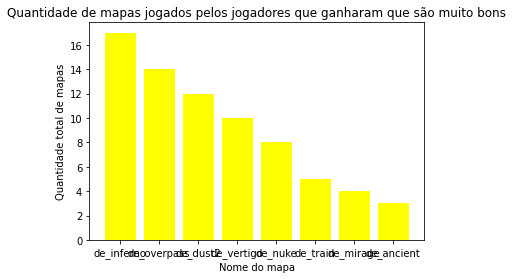

In [111]:
vgpw = playersWinners[playersWinners['playerQuality']=='Muito Bom']
plt.bar(vgpw['descMapName'].unique(), vgpw['descMapName'].value_counts(), color='yellow')
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores que ganharam que são muito bons')
plt.show()

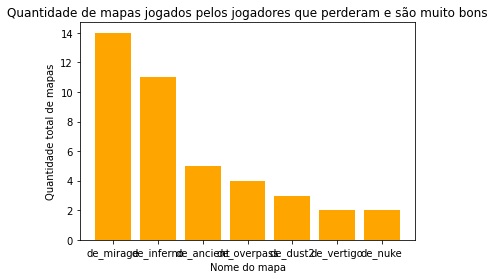

In [112]:
vgpl = playersLosers[playersLosers['playerQuality']=='Muito Bom']
plt.bar(vgpl['descMapName'].unique(), vgpl['descMapName'].value_counts(), color='orange')
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores que perderam e são muito bons')
plt.show()

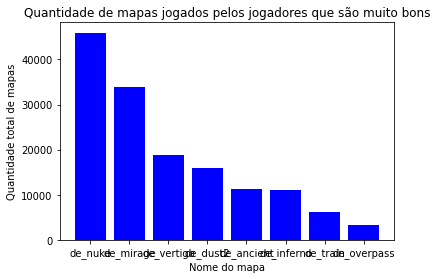

In [139]:
plt.bar(df_l['descMapName'].unique(), df_l['descMapName'].value_counts(), color='blue')
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores do database')
plt.show()

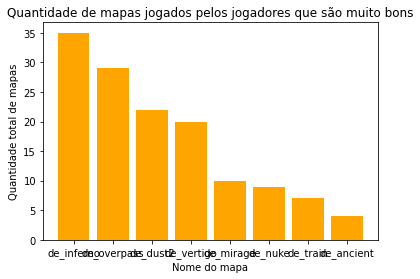

In [138]:
vgp = df_l[df_l['pps']>=60]
plt.bar(vgp['descMapName'].unique(), vgp['descMapName'].value_counts(), color='orange')
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores que são muito bons')
plt.show()
#jogadores com qualidade alta tendem a jogar mais inferno -> Over -> dust2 -> vertigo -> Mirage -> Nuke -> Train -> Ancient

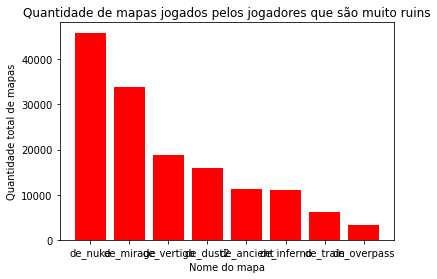

In [140]:
vgp = df_l[df_l['pps']<=60]
plt.bar(vgp['descMapName'].unique(), vgp['descMapName'].value_counts(), color='red')
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores que são muito ruins')
plt.show()

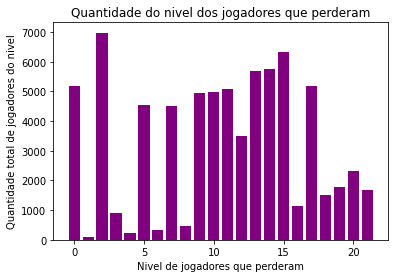

In [113]:
plt.bar(playersLosers['vlLevel'].unique(), playersLosers['vlLevel'].value_counts(), color='purple')
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Quantidade do nivel dos jogadores que perderam')
plt.show()

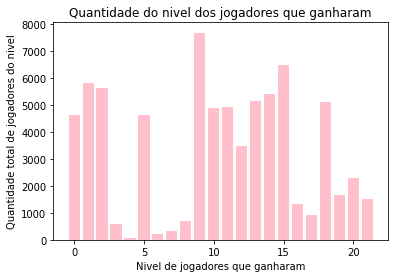

In [114]:
plt.bar(playersWinners['vlLevel'].unique(), playersWinners['vlLevel'].value_counts(), color='pink')
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que ganharam')
plt.title('Quantidade do nivel dos jogadores que ganharam')
plt.show()

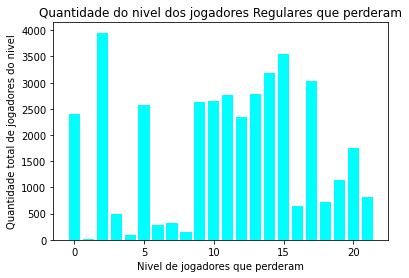

In [115]:
rpl = playersLosers[playersLosers['playerQuality']=='Regular']
plt.bar(rpl['vlLevel'].unique(), rpl['vlLevel'].value_counts(), color='cyan')
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Quantidade do nivel dos jogadores Regulares que perderam')
plt.show()

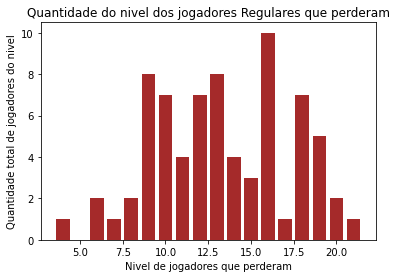

In [116]:
rpl = playersWinners[playersWinners['playerQuality']=='Muito Bom']
plt.bar(rpl['vlLevel'].unique(), rpl['vlLevel'].value_counts(), color='brown')
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Quantidade do nivel dos jogadores Regulares que perderam')
plt.show()

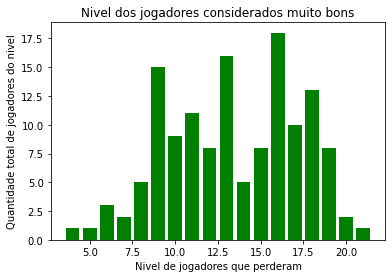

In [143]:
rpl = df_l[df_l['pps']>=60]
plt.bar(rpl['vlLevel'].unique(), rpl['vlLevel'].value_counts(), color='green')
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Nivel dos jogadores considerados muito bons')
plt.show()

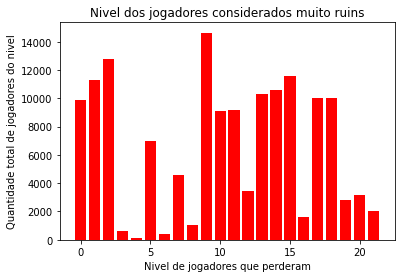

In [142]:
rpl = df_l[df_l['pps']<=60]
plt.bar(rpl['vlLevel'].unique(), rpl['vlLevel'].value_counts(), color='red')
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Nivel dos jogadores considerados muito ruins')
plt.show()

In [118]:
df_l['pps'].describe()

count    146441.000000
mean         23.866106
std           8.441323
min           0.000000
25%          17.857143
50%          22.857143
75%          29.285714
max          90.714286
Name: pps, dtype: float64

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'kpr por mapa')

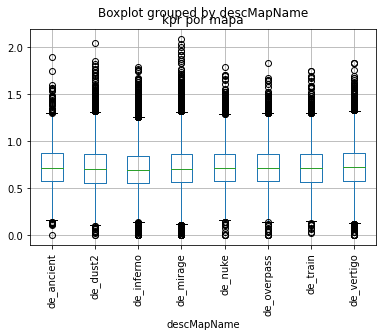

In [119]:
killPorMapa = df_l.boxplot(column='kpr',by="descMapName", rot =90)
killPorMapa.set_title("kpr por mapa")
#inconclusivo por enquanto, pois o mapa que tem mais kills também é o mapa mais jogado
#isso deve ser calculado com base na media de kills por partida 

In [120]:
x = df_l.groupby('descMapName')
y = x['qtKill'].count()
x['qtKill'].describe()
#MEDIA DE KILLS POR MAPA

,count,mean,std,min,25%,50%,75%,max
descMapName,,,,,,,,
de_ancient,3387.0,20.859463,7.154590,0.0,16.0,20.0,25.0,61.0
de_dust2,18761.0,20.382282,7.161748,0.0,15.0,20.0,25.0,85.0
de_inferno,33851.0,20.092878,6.847048,0.0,15.0,19.0,24.0,70.0
de_mirage,45901.0,20.548093,7.164280,0.0,16.0,20.0,25.0,73.0
de_nuke,11211.0,20.731514,7.000101,0.0,16.0,20.0,25.0,60.0
de_overpass,11156.0,20.740498,6.976928,0.0,16.0,20.0,25.0,67.0
de_train,6168.0,20.541180,7.106518,1.0,16.0,20.0,25.0,68.0
de_vertigo,16006.0,20.820317,7.143809,0.0,16.0,20.0,25.0,63.0


In [121]:
x = df_l.groupby('descMapName')
y = x['qtClutchWon'].count()
x['qtClutchWon'].describe()
#MEDIA DE CLUTCH POR MAPA

,count,mean,std,min,25%,50%,75%,max
descMapName,,,,,,,,
de_ancient,3387.0,0.536758,0.756967,0.0,0.0,0.0,1.0,6.0
de_dust2,18761.0,0.501626,0.733896,0.0,0.0,0.0,1.0,5.0
de_inferno,33851.0,0.473634,0.711443,0.0,0.0,0.0,1.0,8.0
de_mirage,45901.0,0.501514,0.731625,0.0,0.0,0.0,1.0,6.0
de_nuke,11211.0,0.535545,0.763378,0.0,0.0,0.0,1.0,7.0
de_overpass,11156.0,0.524919,0.748168,0.0,0.0,0.0,1.0,6.0
de_train,6168.0,0.513619,0.739102,0.0,0.0,0.0,1.0,5.0
de_vertigo,16006.0,0.544546,0.766029,0.0,0.0,0.0,1.0,8.0


In [122]:
x = df_l.groupby('descMapName')
y = x['kpr'].count()
x['kpr'].describe()

#MEDIA DE KPR POR MAPA

,count,mean,std,min,25%,50%,75%,max
descMapName,,,,,,,,
de_ancient,3387.0,0.733093,0.222566,0.000000,0.583333,0.720000,0.870953,1.888889
de_dust2,18761.0,0.719231,0.225644,0.000000,0.560000,0.703704,0.862069,2.043478
de_inferno,33851.0,0.707766,0.215367,0.000000,0.560000,0.695652,0.840000,1.791667
de_mirage,45901.0,0.725325,0.226108,0.000000,0.566667,0.708333,0.866667,2.083333
de_nuke,11211.0,0.730884,0.219042,0.000000,0.583333,0.720000,0.866667,1.791667
de_overpass,11156.0,0.729719,0.217298,0.000000,0.576923,0.720000,0.866667,1.833333
de_train,6168.0,0.725963,0.223969,0.027778,0.571429,0.714286,0.862069,1.750000
de_vertigo,16006.0,0.734101,0.222927,0.000000,0.576923,0.722222,0.875000,1.827586


In [123]:
kill = df_l.qtKill.sum() #quantidade de kills do DataBase
flash = df_l.qtFlashAssist.sum()

flash/kill #porcentagem de kills que tiveram auxilio de flashs
#aproximadamente 2% das kills apenas tem assistencia de flashs

0.02992931984727354

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, '')

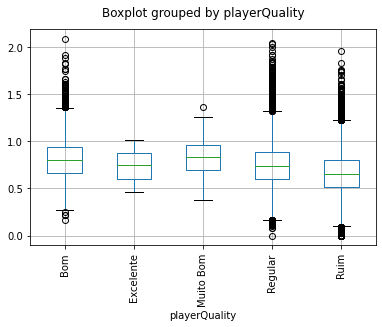

In [124]:
killPorQualidade = df_l.boxplot(column='kpr',by="playerQuality", rot =90)
killPorQualidade.set_title("")

In [125]:
win = df_l['flWinner']>0
win.value_counts()

True     73242
False    73199
Name: flWinner, dtype: int64

In [126]:
a = df_l[['dpr', 'qtSurvived']]
b = df_l[['vlDamage', 'qtKill']]

In [127]:
a.corr()

,dpr
dpr,1.0


In [128]:
b.corr()

,vlDamage,qtKill
vlDamage,1.000000,0.948241
qtKill,0.948241,1.000000


In [129]:
df_l['qtHs'].describe()

count    146441.000000
mean          8.148005
std           4.008621
min           0.000000
25%           5.000000
50%           8.000000
75%          10.000000
max          41.000000
Name: qtHs, dtype: float64

In [130]:
# Calcular %hs
def phs(qtHs, kills):
  phs = qtHs/kills #quanto mais alto melhor 
  return phs

In [131]:
df_l.insert((df_l.shape[1]),"phs",phs(df_l['qtHs'], df_l['qtKill']),True)#Percentual de kills por hs (headshot)

In [132]:
df_l

,idLobbyGame,idPlayer,idRoom,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qt1Kill,...,vlLevel,qtSurvived,qtTrade,qtFlashAssist,flWinner,kpr,dpr,pps,playerQuality,phs
1,2,1,2,24,3,18,6,0,4,9,...,9,8.0,1.0,0.0,1,0.888889,0.666667,23.571429,Regular,0.250000
2,3,2,3,6,4,23,2,0,1,4,...,2,2.0,3.0,0.0,0,0.240000,0.920000,17.857143,Ruim,0.333333
3,3,391,27508,10,5,20,4,1,0,6,...,15,3.0,4.0,0.0,1,0.400000,0.800000,23.571429,Regular,0.400000
4,4,2,4,8,4,26,6,0,2,4,...,2,4.0,4.0,2.0,0,0.266667,0.866667,22.857143,Regular,0.750000
11,10,2,10,19,2,21,7,0,0,9,...,2,6.0,3.0,3.0,0,0.703704,0.777778,18.571429,Ruim,0.368421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184146,172906,2716,178495,17,3,19,7,0,2,12,...,9,9.0,4.0,0.0,0,0.607143,0.678571,20.714286,Regular,0.411765
184147,172907,2716,178496,21,3,13,5,1,1,8,...,9,11.0,0.0,0.0,1,0.807692,0.500000,15.714286,Ruim,0.238095
184148,172908,2716,178497,15,1,22,5,0,1,11,...,9,7.0,5.0,0.0,1,0.517241,0.758621,18.571429,Ruim,0.333333
184149,172909,2716,178498,9,6,23,2,0,3,9,...,9,4.0,2.0,0.0,0,0.333333,0.851852,25.000000,Regular,0.222222


In [133]:
#para se colocar alguma afirmação deve saber pela quantidade de rounds jogados? Podemos considerar que a partir de uma quantidade minima de rounds para entrar no calculo? partidas muito longas podem ser retiradas?
df_l.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146441 entries, 1 to 184150
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   idLobbyGame     146441 non-null  int64  
 1   idPlayer        146441 non-null  int64  
 2   idRoom          146441 non-null  int64  
 3   qtKill          146441 non-null  int64  
 4   qtAssist        146441 non-null  int64  
 5   qtDeath         146441 non-null  int64  
 6   qtHs            146441 non-null  int64  
 7   qtBombeDefuse   146441 non-null  int64  
 8   qtBombePlant    146441 non-null  int64  
 9   qt1Kill         146441 non-null  int64  
 10  qt2Kill         146441 non-null  int64  
 11  qt3Kill         146441 non-null  int64  
 12  qt4Kill         146441 non-null  int64  
 13  qt5Kill         146441 non-null  int64  
 14  qtFirstKill     146441 non-null  int64  
 15  vlDamage        146441 non-null  int64  
 16  qtHits          146441 non-null  float64
 17  qtLastAliv

In [134]:
#regras de associação